In [1]:
import torch
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
import os

NUM_CLASSES = int(os.getenv('NUM_CLASSES', 37))
BATCH_SIZE = int(os.getenv('BATCH_SIZE', 256))
IMAGE_SIZE = int(os.getenv('IMAGE_SIZE', 128))

In [2]:
# Define custom dataset to apply transformations
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Define transformation functions
def resize(img):
    transform = transform=v2.Compose([v2.Resize((IMAGE_SIZE, IMAGE_SIZE)), v2.ToDtype(torch.float32, scale=True)])
    img = transform(img)
    return img

def central_crop(img):
    transform = v2.Compose([
        v2.CenterCrop(int(IMAGE_SIZE * 0.85)),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.RandomHorizontalFlip(p=1.0),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize((0.5,), (0.5,))
    ])
    img = transform(img)
    return img

def top_left_crop(img):
    h = img.shape[1]
    w = img.shape[2]
    cut = 0.86
    img = img[:,:int(h*cut),:int(w*cut)]
    transform = v2.Compose([
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ColorJitter(hue=0.45),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize((0.5,), (0.5,))
    ])
    img = transform(img)
    return img

def top_right_crop(img):
    h = img.shape[1]
    w = img.shape[2]
    cut = 0.86
    img = img[:,:int(h*cut),int(w*(1-cut)):]
    transform = v2.Compose([
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ColorJitter(brightness=0.3),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize((0.5,), (0.5,))
    ])
    img = transform(img)
    return img

def bottom_left_crop(img):
    h = img.shape[1]
    w = img.shape[2]
    cut = 0.86
    img = img[:,int(h*(1-cut)):,:int(w*cut)]
    transform = v2.Compose([
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ColorJitter(saturation=(0.4, 2)),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize((0.5,), (0.5,))
    ])
    img = transform(img)
    return img

def bottom_right_crop(img):
    h = img.shape[1]
    w = img.shape[2]
    cut = 0.86
    img = img[:,int(h*(1-cut)):,int(w*(1-cut)):]
    transform = v2.Compose([
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ColorJitter(contrast=(0.5, 1.5)),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize((0.5,), (0.5,))
    ])
    img = transform(img)
    return img

# Define the data augmentation function
def data_augment(train_dataset, val_dataset):
    # dataset(uint8) \
    # |---> (resize) (rescale) ---> org \
    # |---> (central_crop) (resize) (flip_left_right) (recale)---> temp1 \
    # |---> (top_left_crop) (resize) (random_hue) (random_flip_left_right) (rescale)---> temp2 \
    # |---> (top_right_crop) (resize) (random_brightness) (random_flip_left_right) (rescale)---> temp3 \
    # |---> (bottom_left_crop) (resize) (random_saturation) (random_flip_left_right) (rescale)---> temp4 \
    # |---> (bottom_right_crop) (resize) (random_contrast) (random_flip_left_right) (rescale)---> temp5 \
    # org + temp1 + temp2 + temp3 + temp4 + temp5 ---> train_ds 
    
    # Augmented datasets
    augmentations = [resize, central_crop, top_left_crop, top_right_crop, bottom_left_crop, bottom_right_crop]
    augmented_datasets = [CustomDataset(train_dataset, transform=v2.Lambda(aug)) for aug in augmentations]

    # Combine original and augmented datasets
    train_dataset = ConcatDataset(augmented_datasets)
    val_dataset = CustomDataset(val_dataset, transform=resize)  

    return train_dataset, val_dataset


In [3]:
# Define the one hot encode function for the labels
def one_hot_encode(x):
    return torch.nn.functional.one_hot(torch.tensor(x), num_classes=NUM_CLASSES)


# Load the dataset; transform PIL to tensor image(uint8[0-255]) and one-hot encode the labels
train_dataset = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=v2.ToImage(),
                    target_transform=v2.Lambda(one_hot_encode) )
temp_val_dataset = torchvision.datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=v2.ToImage(),
                    target_transform=v2.Lambda(one_hot_encode) )

# Define the split ratio for val_dataset
part_train_size = int(0.7 * len(temp_val_dataset))
val_size = len(temp_val_dataset) - part_train_size


# Split the dataset into part_training and val sets
part_train_dataset, val_dataset = random_split(temp_val_dataset, [part_train_size, val_size], generator=torch.Generator().manual_seed(42))

# Combine the part_train_dataset and train_dataset into a single train_dataset
train_dataset = ConcatDataset([train_dataset, part_train_dataset])

# Apply data augmentation
train_dataset, val_dataset = data_augment(train_dataset, val_dataset)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Training dataset size: 37488
Validation dataset size: 1101


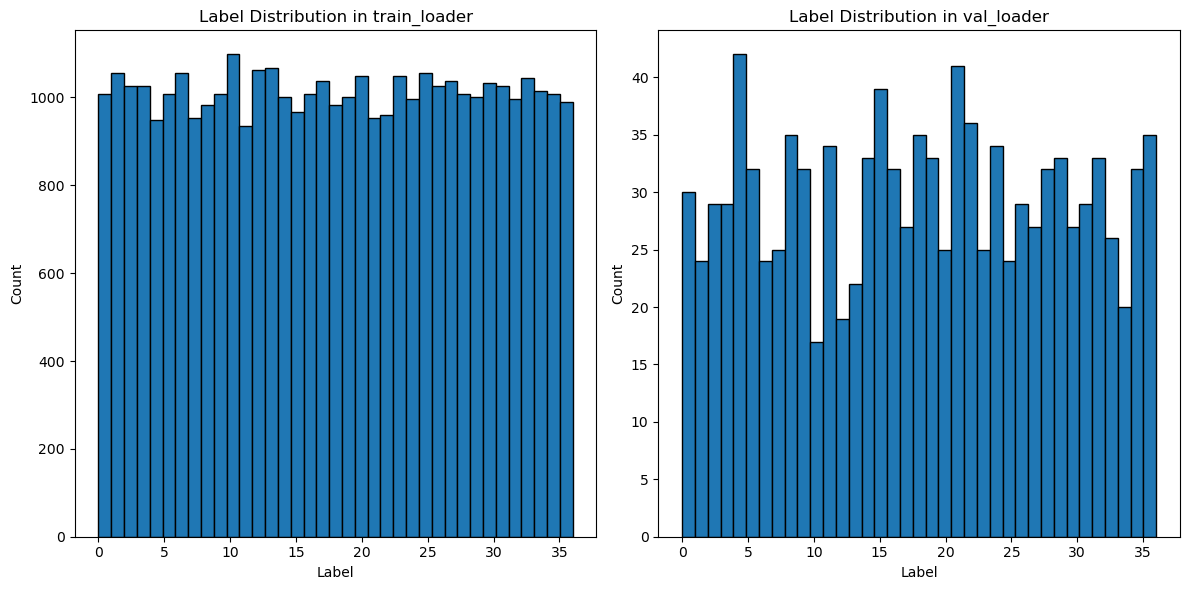

In [4]:
import matplotlib.pyplot as plt

# Extract labels from train_loader
train_labels = []
for _, labels in train_loader:
    class_indices = torch.argmax(labels, dim=1)
    train_labels.extend(class_indices.tolist())

# Extract labels from val_loader
val_labels = []
for _, labels in val_loader:
    class_indices = torch.argmax(labels, dim=1)
    val_labels.extend(class_indices.tolist())

# Create histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=NUM_CLASSES, edgecolor='black')
plt.title('Label Distribution in train_loader')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(val_labels, bins=NUM_CLASSES, edgecolor='black')
plt.title('Label Distribution in val_loader')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()